# The Source Code for Lab Exercise 3.
## Steps
1. Preprocess the Data.
2. Create a Train and Test Split
3. Create a Convolutional Neural Network using Keras.
4. Experiment on Various Elements
5. Discussion and Analysis of Experiments.

# Possible Things to Experiment on
1. Other Preprocessing methods for Images.
2. Adding Max Pooling.
3. Changing number of Filters.
4. Changing Kernel Size.
5. Changing Learning Rate.
6. Changing Optimizers.
7. TBA

### Checking the Dataset for valid Image types

In [40]:
from pathlib import Path
import imghdr
import os

DATA_DIR = "hair_types"
IMAGE_EXTENSIONS = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

### Preprocessing Images and Creating Train/Test Splits using Keras util methods
#### Learn more:
```
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
```

In [41]:
# Import Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Define parameters for preprocessor
BATCH_SIZE = 32
HEIGHT = 64
WIDTH = 64

### Preprocessing images from Scratch

In [42]:
# Generating a dataset using keras.util
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    labels='inferred'
)

Found 985 files belonging to 3 classes.
Using 788 files for training.
Using 197 files for validation.


### Visualizing the Initial Dataset

2024-04-10 23:40:55.846836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


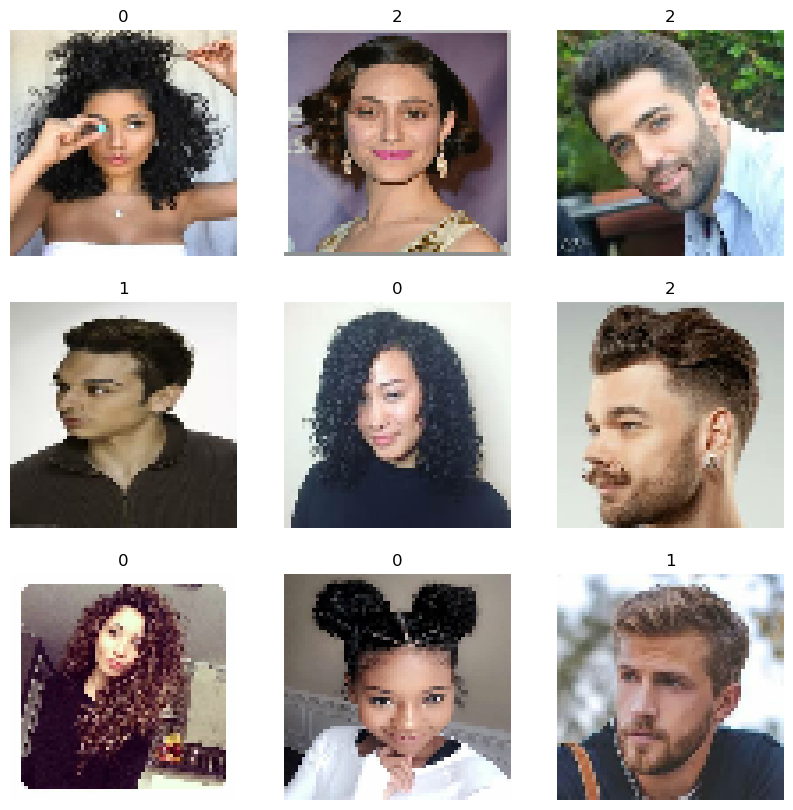

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

#### Data Augmentation
##### Since the image data is not that many, we artificially produce sample images by flipping or rotating the present images.

In [44]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
]
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

#### Visualizing Data Augmentation

2024-04-10 23:40:56.674267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


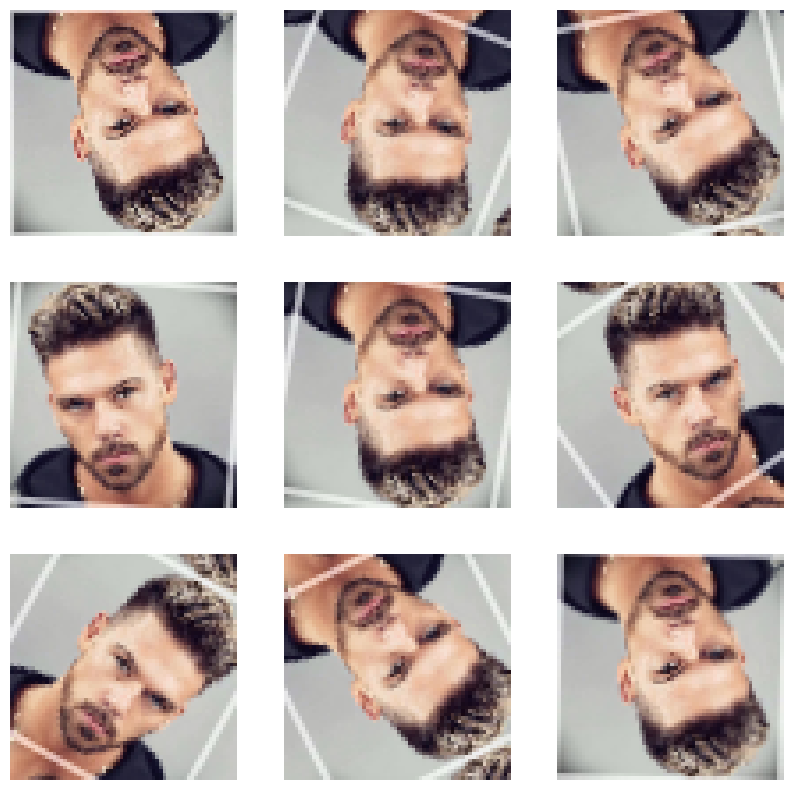

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

In [46]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Apply `data_augmentation` to the training images.
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE)

### Creating the CNN Model

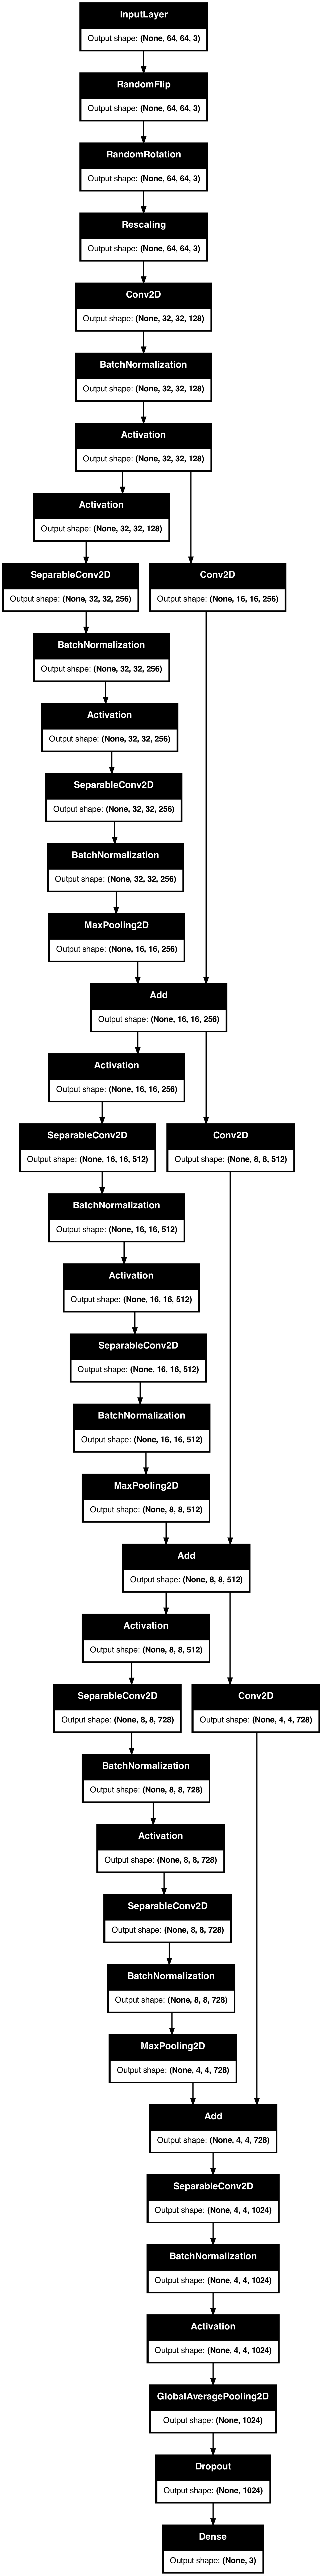

In [47]:
# 2. Adding Max Pooling.
# 3. Changing number of Filters.
# 4. Changing Kernel Size.

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(HEIGHT, WIDTH) + (3,), num_classes=3)
tf.keras.utils.plot_model(model, to_file='test_logs//model_test.png', show_shapes=True)
# keras.optimizers.SGD

### Training of the Model

In [48]:
# 5. Changing Learning Rate.
# 6. Changing Optimizers.
EPOCHS = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("test_logs/checkpoint/save_at_{epoch}.keras"),
]
model.compile(
    #  optimizer=keras.optimizers.Adam(learning_rate=0.001),
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')],
)
cnn = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)
model.summary()

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.4284 - loss: 1.1356 - val_accuracy: 0.3604 - val_loss: 1.0979
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.4773 - loss: 1.0527 - val_accuracy: 0.3604 - val_loss: 1.0997
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4842 - loss: 1.0548 - val_accuracy: 0.3604 - val_loss: 1.1004
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.4704 - loss: 1.0553 - val_accuracy: 0.2843 - val_loss: 1.1125
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5246 - loss: 1.0320 - val_accuracy: 0.2843 - val_loss: 1.1161
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5002 - loss: 1.0267 - val_accuracy: 0.2843 - val_loss: 1.1244
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5275 - loss: 0.9549 - val_accuracy: 0.3147 - val_loss: 1.1124
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5400 - loss: 0.9155 - val_accuracy: 0

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_3       │ (None, 64, 64, 3) │          0 │ input_layer_3[0]… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_3   │ (None, 64, 64, 3) │          0 │ random_flip_3[0]… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 64, 64, 3) │          0 │ random_rotation_… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │      3,584 │ rescaling_3[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 32, 32,    │          0 │ activation_24[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_21 │ (None, 32, 32,    │     34,176 │ activation_25[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_22 │ (None, 32, 32,    │     68,096 │ activation_26[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │     33,024 │ activation_24[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_9[… │
│                     │ 256)              │            │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 16, 16,    │          0 │ add_9[0][0]     

 Total params: 5,457,944 (20.82 MB)

 Trainable params: 2,724,827 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

 Optimizer params: 2,724,829 (10.39 MB)

### Evaluation of the Model

In [49]:
img_path = "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg"
img = keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Predict probabilities
predictions = model.predict(img_array)[0]  

# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
This image is 100.00 percent Curly Hair, 0.00 percent Straight Hair, 0.00 percent Wavy Hair.


### Visualization of Model with respect to Epochs

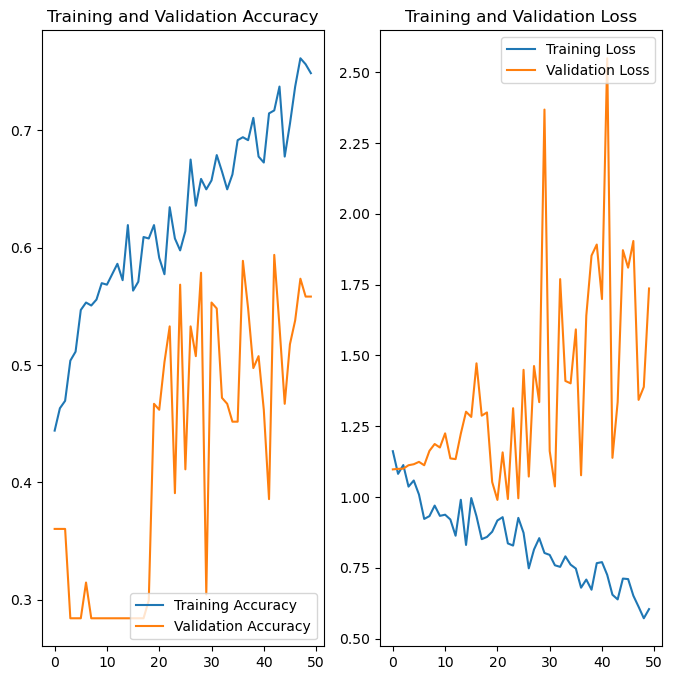

In [50]:
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']

loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()